In [40]:
"""
``autoreload`` is an IPython extension that reloads modules
automatically before executing the line of code typed.
"""

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Timeseries forecasting with ARIMA model

---

## Loading modules and reading the data

In [41]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [42]:
RAW_DATA_PATH = Path('__file__').resolve().parents[1] / 'data' / '01_raw'
PROCESSED_DATA_PATH = Path('__file__').resolve().parents[1] / 'data' / '02_processed'

In [43]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.figsize'] = [15, 8]

In [44]:
sns.set_style('whitegrid')

In [45]:
def read_and_format_csv(subfolder_path: Path, raw_path: bool = True) -> pd.DataFrame:
    if raw_path:
        path = str(RAW_DATA_PATH / subfolder_path)
        df = pd.read_csv(path)
    else:
        path = str(PROCESSED_DATA_PATH / subfolder_path)
        df = pd.read_csv(path)
        
    
    df = df.astype({col: 'float32' for col in ['Open', 'High', 'Low', 'Close', 'Adj Close',]})
    df['stock_name'] = df['stock_name'].astype('str')
    df['Volume'] = df['Volume'].astype('int32')

    df['Date'] = pd.to_datetime(df['Date'], format='ISO8601', utc='True')
    df['Date'] = pd.to_datetime(df['Date'].dt.date)
    return df

In [46]:
df = read_and_format_csv(subfolder_path='Information_Technology/AAPL.csv', raw_path=True)

In [47]:
df.sort_values(by='Date', inplace=True)
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume,stock_name
0,1980-12-12,0.098834,0.128348,0.128906,0.128348,0.128348,469033600,AAPL
1,1980-12-15,0.093678,0.121652,0.122210,0.121652,0.122210,175884800,AAPL
2,1980-12-16,0.086802,0.112723,0.113281,0.112723,0.113281,105728000,AAPL
3,1980-12-17,0.088951,0.115513,0.116071,0.115513,0.115513,86441600,AAPL
4,1980-12-18,0.091530,0.118862,0.119420,0.118862,0.118862,73449600,AAPL


In [48]:
df.dtypes

Date          datetime64[ns]
Adj Close            float32
Close                float32
High                 float32
Low                  float32
Open                 float32
Volume                 int32
stock_name            object
dtype: object

#### Notes about the dataset

<ul>
    <li>Daily resolution Apple stock Dataset</li>
    <li>The currency used is American dollar</li>
</ul>

## Focusing on Daily resolution and returns

---

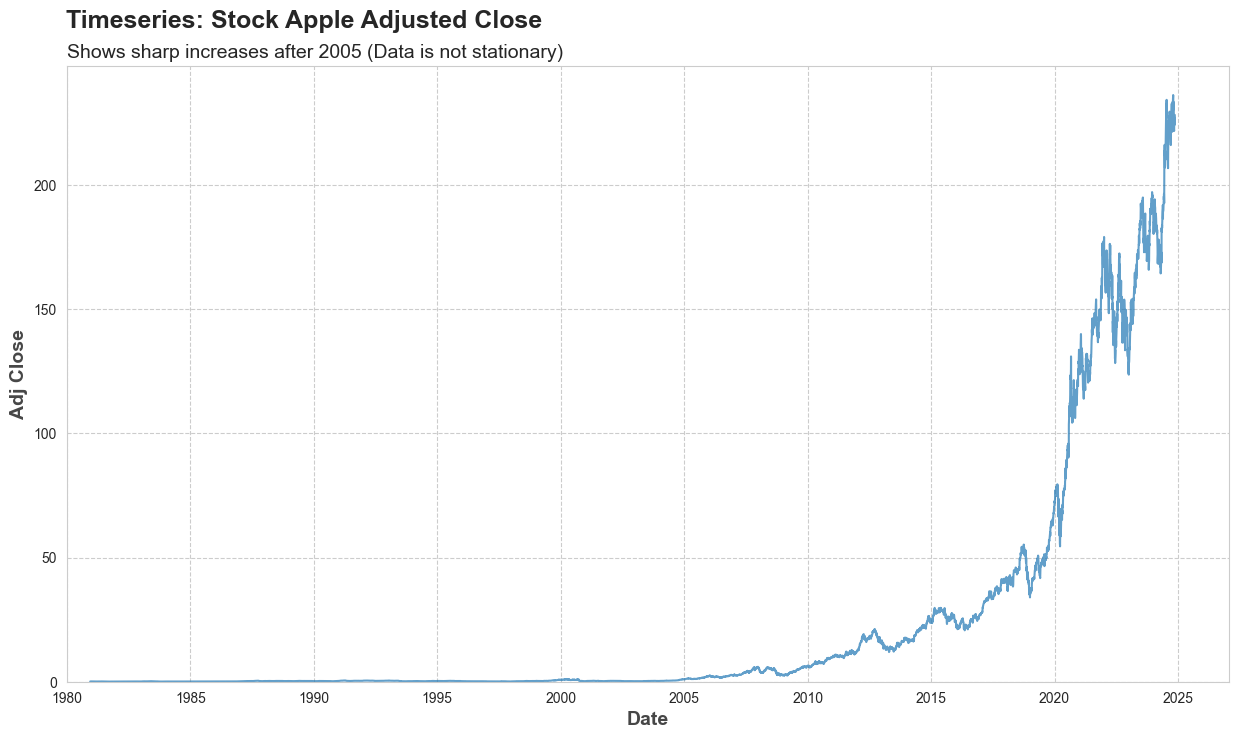

In [49]:
f, ax = plt.subplots(nrows=1, ncols=1,)

sns.lineplot(data=df, x='Date', y='Adj Close', markers='o', alpha=0.7)

ax.set_xlabel('Date', fontsize=14, alpha=0.85, fontweight='bold')
ax.set_ylabel('Adj Close', fontsize=14, alpha=0.85, fontweight='bold')

dx, dy = 0.2835, 0.95
f.suptitle(t='Timeseries: Stock Apple Adjusted Close', fontsize=18, x=dx, y=dy, fontweight='bold')
ax.set_title(label='Shows sharp increases after 2005 (Data is not stationary)', fontsize=14, loc='left')

ax.set_xlim(df['Date'].min() + timedelta(days=-350))
ax.set_ylim(0)
ax.grid(linestyle='--',)
plt.show()


We can see from this Timeseries that it has Trends but No clearn evidence of seasonality and is definitely not stationary so we need to transform it, I believe I should use first difference or normalised difference (pct change)

In [50]:
df['Returns'] = df['Adj Close'].pct_change()
df['first_diff'] = df['Adj Close'].diff()
df.head(2)

,Date,Adj Close,Close,High,Low,Open,Volume,stock_name,Returns,first_diff
0,1980-12-12,0.098834,0.128348,0.128906,0.128348,0.128348,469033600,AAPL,NaN,NaN
1,1980-12-15,0.093678,0.121652,0.122210,0.121652,0.122210,175884800,AAPL,-0.052171,-0.005156


In [51]:
df = df.loc[df['Date'].dt.year > pd.Timestamp('1980').year].reset_index(drop=True)
df.head(2)

,Date,Adj Close,Close,High,Low,Open,Volume,stock_name,Returns,first_diff
0,1981-01-02,0.118602,0.154018,0.155134,0.154018,0.154018,21660800,AAPL,0.010989,0.001289
1,1981-01-05,0.116024,0.150670,0.151228,0.150670,0.151228,35728000,AAPL,-0.021738,-0.002578


In [52]:
df.iloc[:, 1:].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

,Adj Close,Close,High,Low,Open,Volume,Returns,first_diff
count,11061.000000,11061.000000,11061.000000,11061.000000,11061.000000,1.106100e+04,11061.000000,11061.000000
mean,22.893742,23.732557,23.969788,23.473480,23.716425,3.025108e+08,0.001077,0.020622
std,48.389786,48.864780,49.337860,48.341076,48.823273,3.215887e+08,0.027785,0.916040
min,0.037815,0.049107,0.049665,0.049107,0.049665,-2.108338e+09,-0.518692,-10.566132
10%,0.103992,0.134487,0.137277,0.132813,0.135045,6.835660e+07,-0.028096,-0.176617
25%,0.243658,0.300781,0.306429,0.292411,0.300223,1.110652e+08,-0.012620,-0.008989
50%,0.442485,0.540179,0.549107,0.531250,0.540179,2.030448e+08,0.000000,0.000000
75%,17.913139,20.999643,21.236429,20.821428,21.079287,3.933552e+08,0.014385,0.014069
90%,87.711876,90.014999,91.250000,88.254997,90.019997,7.011536e+08,0.030815,0.261644
99%,197.054633,198.020004,198.887994,195.934000,197.151996,1.504470e+09,0.077555,3.431161


Minimum volume is negative, this is potentially an error we have to explore

#### Exploring negative volume values

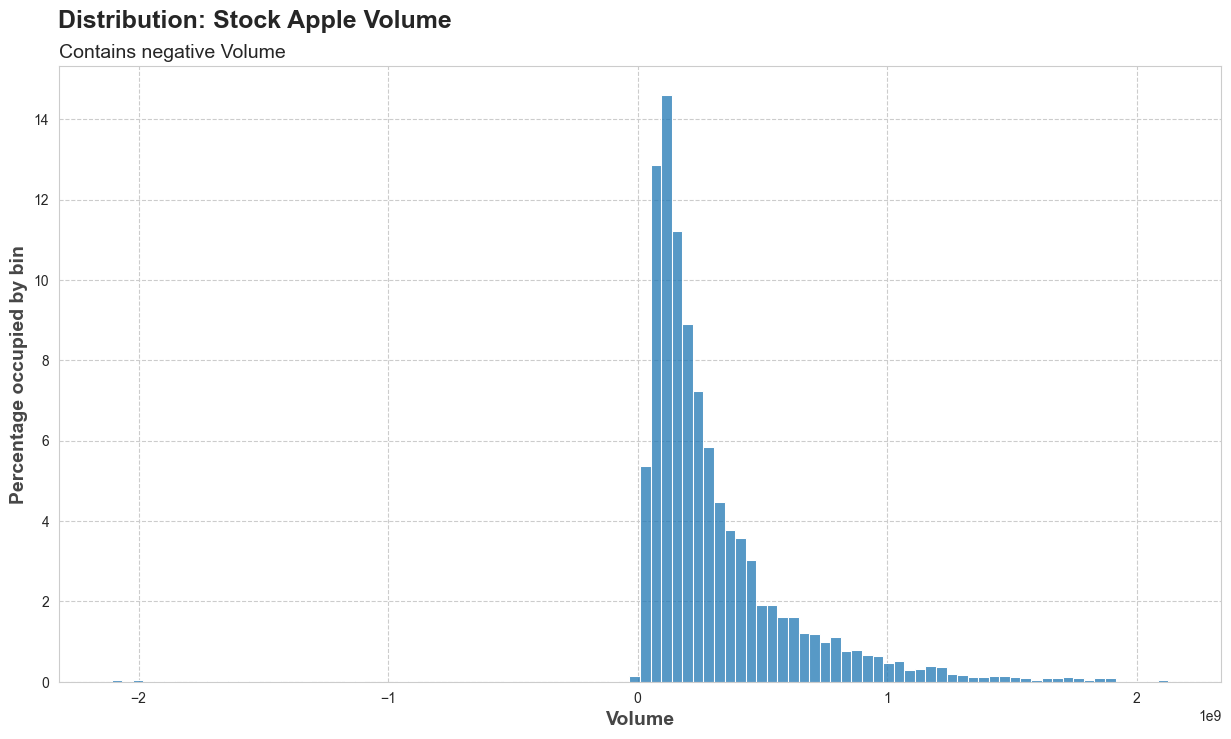

In [53]:
f, ax = plt.subplots()
sns.histplot(df['Volume'], bins=100, stat='percent', ax=ax)

ax.set_xlabel('Volume', fontsize=14, alpha=0.85, fontweight='bold')
ax.set_ylabel('Percentage occupied by bin', fontsize=14, alpha=0.85, fontweight='bold')

dx, dy = 0.256, 0.95
f.suptitle(t='Distribution: Stock Apple Volume', fontsize=18, x=dx, y=dy, fontweight='bold')
ax.set_title(label='Contains negative Volume', fontsize=14, loc='left')


ax.grid(linestyle='--',)
plt.show()

In [54]:
df[df['Volume'] < 0].head()

,Date,Adj Close,Close,High,Low,Open,Volume,stock_name,Returns,first_diff
690,1983-09-23,0.083365,0.108259,0.111607,0.099330,0.111607,-1462621696,AAPL,-0.253844,-0.028361
4196,1997-08-06,0.198177,0.234933,0.247768,0.223214,0.225446,-104487296,AAPL,0.332281,0.049427
4197,1997-08-07,0.219831,0.260603,0.263951,0.253348,0.256696,-539528896,AAPL,0.109265,0.021654
4433,1998-07-16,0.282437,0.334821,0.340402,0.319196,0.338170,-1733616896,AAPL,0.088927,0.023065
4496,1998-10-14,0.281496,0.333705,0.368862,0.328683,0.354911,-2014949696,AAPL,-0.035485,-0.010356


I have validated the values in the Adjusted Close columns with negative volumes with true values online and can confirm the values are correct.

#### Exploring Null values and Duplicates

In [61]:
df.isna().sum()

Date          0
Adj Close     0
Close         0
High          0
Low           0
Open          0
Volume        0
stock_name    0
Returns       0
first_diff    0
dtype: int64

In [63]:
df.duplicated().sum()

np.int64(0)

Dataset contains no Null or Duplicate data

#### Extra Cleaning

I could've done additional outlier detection where i remove values 1.5 times the interquatile range but I decided to keep the values as they are. This is because stocks are very volatile and these abnormal returns and price values can happen due to economic events. <br>

Additionally as a safety measure I have compared my timeseries to other sources of truth on the internet and can safely say it looks the same.

---

### Checking the stationarity of Returns and first difference columns

----

returns and first difference are is the percentage change and first difference of the Adj Close columns

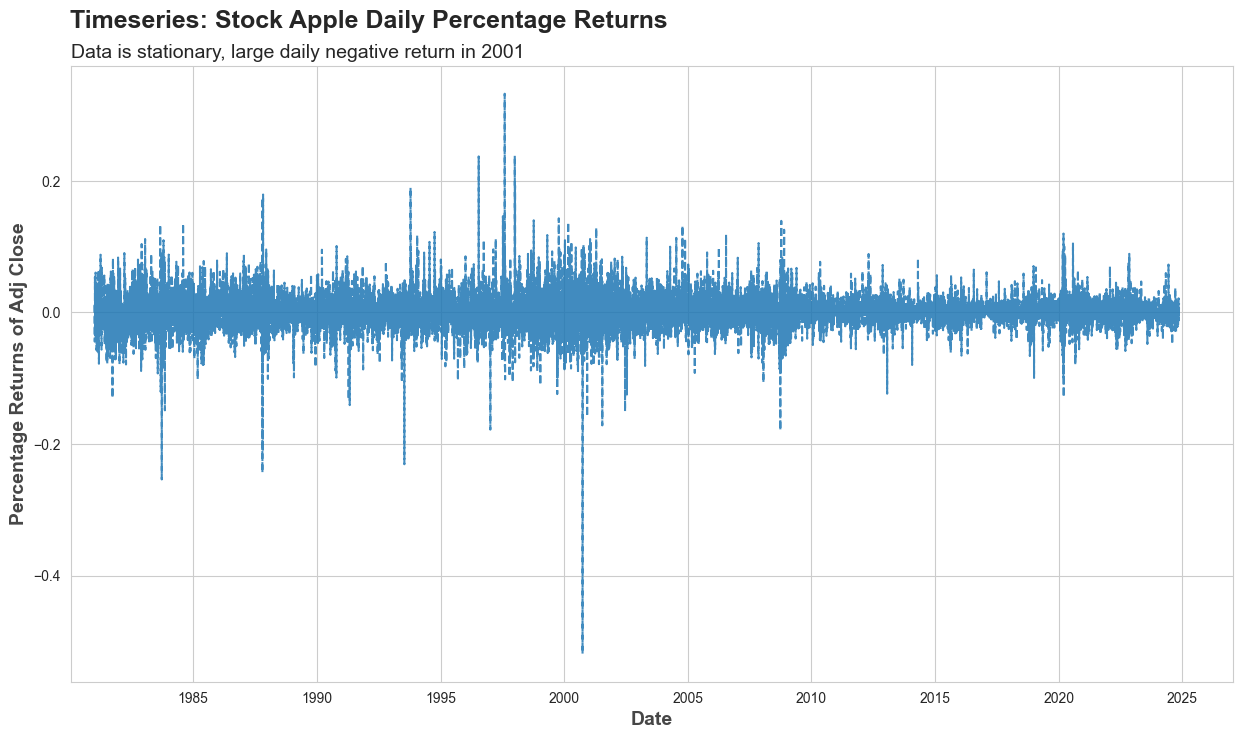

In [55]:
f, ax = plt.subplots()
sns.lineplot(data=df, x='Date', y='Returns', linestyle='--', markers='o', ax=ax, alpha=0.85)


ax.set_xlabel('Date', fontsize=14, alpha=0.85, fontweight='bold')
ax.set_ylabel('Percentage Returns of Adj Close', fontsize=14, alpha=0.85, fontweight='bold')

dx, dy = 0.3235, 0.95
f.suptitle(t='Timeseries: Stock Apple Daily Percentage Returns', fontsize=18, x=dx, y=dy, fontweight='bold')
ax.set_title(label='Data is stationary, large daily negative return in 2001', fontsize=14, loc='left')

ax.set_xlim(df['Date'].min() + timedelta(days=-350))

plt.show()

Timeseries of returns looks stationary maybe left side has more variance than right

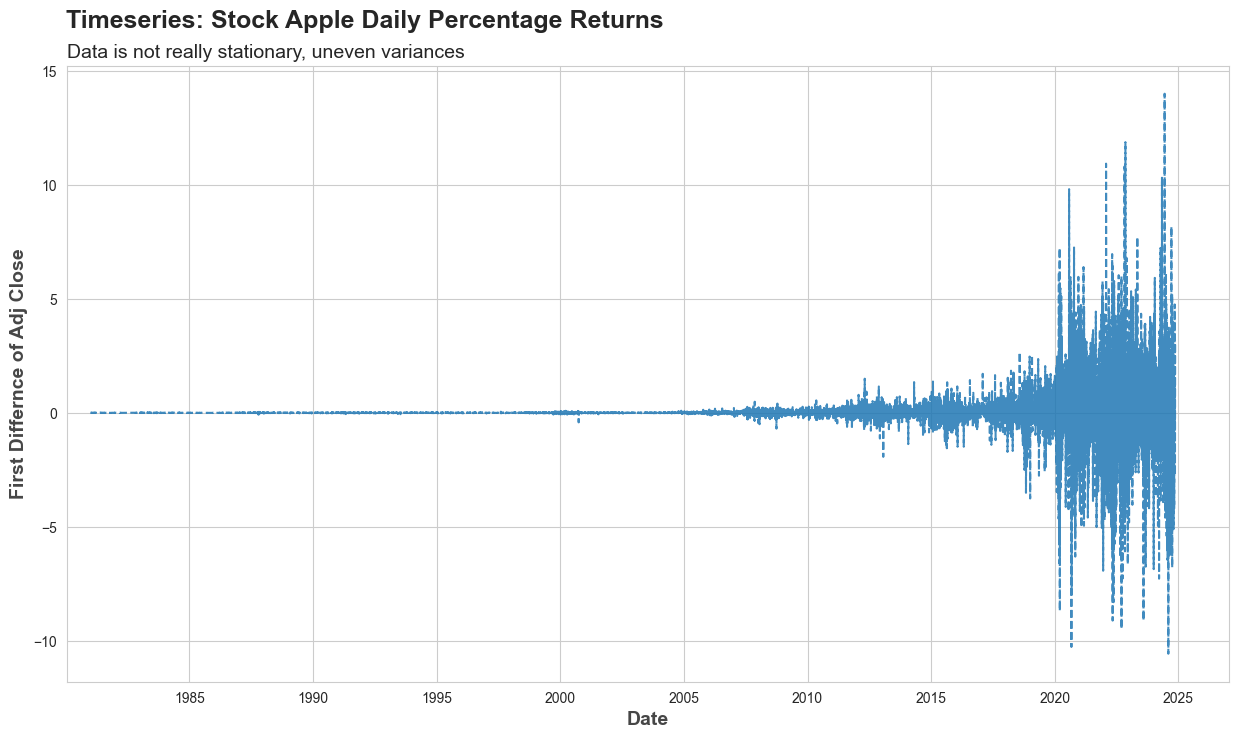

In [56]:
f, ax = plt.subplots()
sns.lineplot(data=df, x='Date', y='first_diff', linestyle='--', markers='o', alpha=0.85)


ax.set_xlabel('Date', fontsize=14, alpha=0.85, fontweight='bold')
ax.set_ylabel('First Differnce of Adj Close', fontsize=14, alpha=0.85, fontweight='bold')

dx, dy = 0.3235, 0.95
f.suptitle(t='Timeseries: Stock Apple Daily Percentage Returns', fontsize=18, x=dx, y=dy, fontweight='bold')
ax.set_title(label='Data is not really stationary, uneven variances', fontsize=14, loc='left')

ax.set_xlim(df['Date'].min() + timedelta(days=-350))
plt.show()

---

### Augmented Dickey Fuller Test

---

In order to use an ARIMA model our data should be stationaly therefore having an normal distribution around the mean and should have no significant changes in the volatility or fluctuations of the data over different time periods. <br>

Therefore we run the Adfuller test, which is a statistical test for stationarity. It works by testing the null hypothesis on a sample that the timeseries in not stationary. Returning test statistics and p-value and Critical values.

In [57]:
from statsmodels.tsa.stattools import adfuller

In [67]:
# First Difference adj close results in really small p_value 3.5*10-30
results = adfuller(df['Returns'], autolag='AIC')
results

(np.float64(-30.002091222511435),
 0.0,
 11,
 11049,
 {'1%': np.float64(-3.4309419829743115),
  '5%': np.float64(-2.861801623995844),
  '10%': np.float64(-2.566909257329274)},
 np.float64(-47752.58355187107))

In [69]:
# pct change adj close results in p-value of 0
results = adfuller(df['first_diff'], autolag='AIC')
results

(np.float64(-17.72607265560365),
 np.float64(3.4513273352450356e-30),
 39,
 11021,
 {'1%': np.float64(-3.430943487319322),
  '5%': np.float64(-2.861802288767382),
  '10%': np.float64(-2.5669096111856504)},
 np.float64(29191.227878541777))

The first item in both tuples are the test statistics which is then used to generate the second value in the tuple the p value <font color=red> If the p value > 0.05 we reject the null hypothesis that the graph is stationary</font> and apply another transform.<br>

Finally the last 3 values contain the test statistic for the critical values, our test statistic ended up bieng a lot lower than these so we can reject the null hypothesis

---

### Plotting ACF and PACF

---

Plotting the ACF and PACF is a good way to identify the correct model order. The Autocorrelation function is the correlation between the time series and an ofset n. So written like this, $\text{corr}(y_t, y_{t-n})$. <br>

The PACF or partial autocorrelation is the correlation between a time series and the lagged version of itself after we take away the effort of the correlation at smaller lags. Which means it is just the correlation associated with that particular lag.

In [66]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#### Plot ACF and PACF graphs

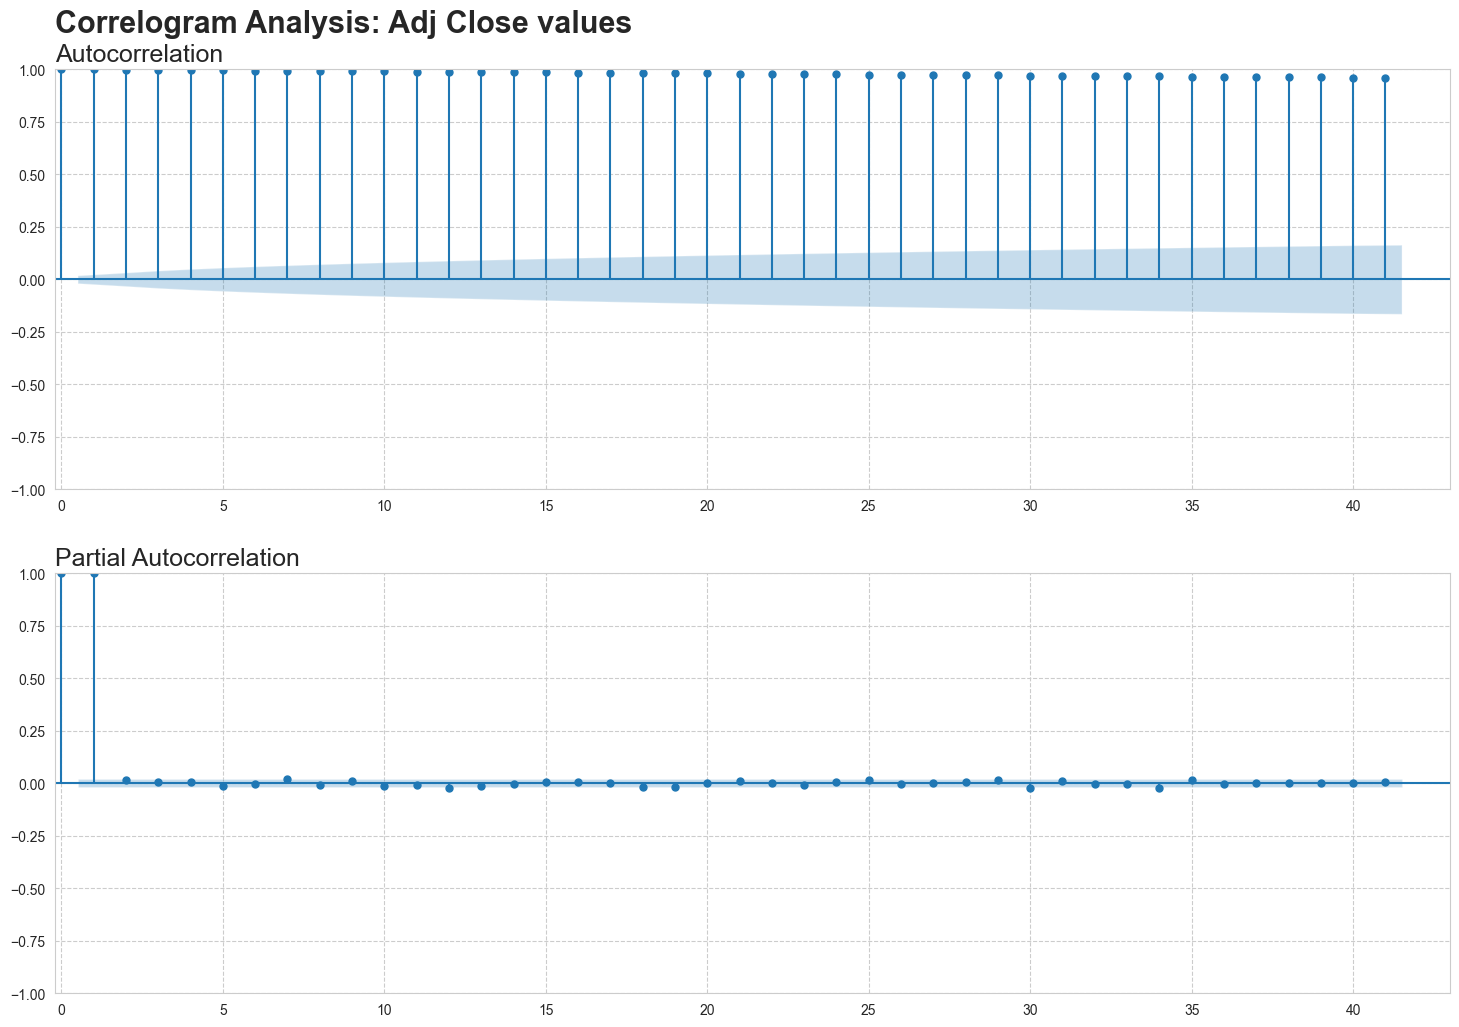

In [109]:
f, ax = plt.subplots(2, 1, figsize=(18, 12))

plot_acf(df['Adj Close'], ax=ax[0], title='')
plot_pacf(df['Adj Close'], ax=ax[1], title='')

dx, dy = 0.2855, 0.93
f.suptitle(t='Correlogram Analysis: Adj Close values', fontsize=22, fontweight='bold', x=dx, y=dy)

ax[0].set_title('Autocorrelation', fontdict={'size': 18, 'weight': 'light'}, loc='left')
ax[1].set_title('Partial Autocorrelation', fontdict={'size': 18, 'weight': 'light'}, loc='left')
for axes in ax:
    axes.set_xlim(-0.2, 43)#
    axes.grid(linestyle='--')
plt.show()

The PACF, effect a number of periods ago to now??

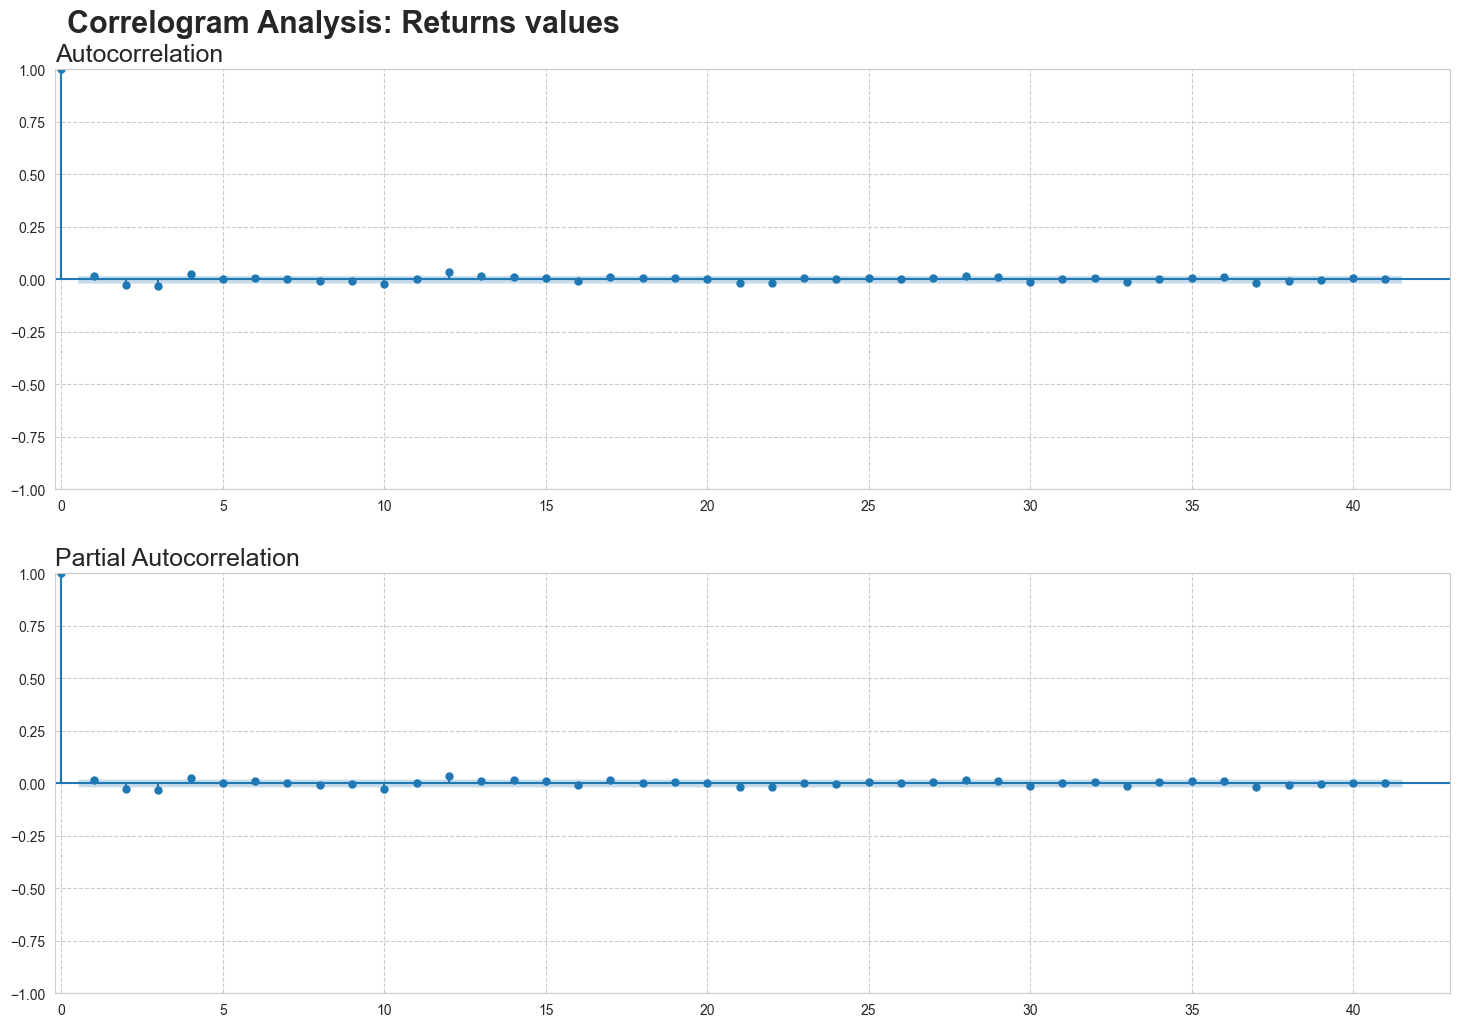

In [110]:
f, ax = plt.subplots(2, 1, figsize=(18, 12))

plot_acf(df['Returns'], ax=ax[0], title='')
plot_pacf(df['Returns'], ax=ax[1], title='')

dx, dy = 0.2855, 0.93
f.suptitle(t='Correlogram Analysis: Returns values', fontsize=22, fontweight='bold', x=dx, y=dy)

ax[0].set_title('Autocorrelation', fontdict={'size': 18, 'weight': 'light'}, loc='left')
ax[1].set_title('Partial Autocorrelation', fontdict={'size': 18, 'weight': 'light'}, loc='left')
for axes in ax:
    axes.set_xlim(-0.2, 43)#
    axes.grid(linestyle='--')
plt.show()

---

### ARIMA Modelling

---

The ARIMA model works by combining the AR and the MA models together. With I or intergrated part bieng the level of differencing done on the data. <br>

An $\text{AR}(p)$ model works by regressing the values of the time series against previous $\text(p)$ values of the same timeseries. So an $\text{AR}(p)$ model works like this below: <br>

$y_t = a_1y_{t-1} + a_2y_{t-2} + ... + a_py_{t-p} + \epsilon_t$ <br>

In a $\text{MA}(q)$ model we regress the values if the timeseries against the previous shock term values of the series. So an $\text{MA}(q)$ model works like this before.

$y_t = m_1\epsilon_{t-1} + m_2\epsilon_{t-2} + ... + m_q\epsilon_{t-q} + \epsilon_t$ <br>

And an $\text{ARMA}(p, q)$ model is just these two models added together so: <br>

$y_t = a_py_{t-p}+ m_q\epsilon_{t-q} + \epsilon_t$

#### Testing model of transformed stationary data no order of differencing

In [123]:
from statsmodels.tsa.arima.model import ARIMA

In [124]:
model_input = df.set_index('Date')['Returns']
model_input.head(2)

Date
1981-01-02    0.010989
1981-01-05   -0.021738
Name: Returns, dtype: float32

In [125]:
p, q = 1, 1

model = ARIMA(model_input, order=(p,0,q))
results = model.fit()
print(results.summary())

d:\Miniconda\envs\data-dev\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Miniconda\envs\data-dev\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Miniconda\envs\data-dev\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                11061
Model:                 ARIMA(1, 0, 1)   Log Likelihood               23940.203
Date:                Wed, 27 Nov 2024   AIC                         -47872.406
Time:                        19:02:38   BIC                         -47843.161
Sample:                             0   HQIC                        -47862.556
                              - 11061                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.000      4.041      0.000       0.001       0.002
ar.L1          0.4917      1.819      0.270      0.787      -3.074       4.058
ma.L1         -0.4939      1.817     -0.272      0.7

#### Testing with one order of differencing

In [126]:
p, d, q = 1, 1, 1

model = ARIMA(model_input, order=(p,d,q))
results = model.fit()
print(results.summary())

d:\Miniconda\envs\data-dev\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Miniconda\envs\data-dev\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Miniconda\envs\data-dev\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Miniconda\envs\data-dev\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                11061
Model:                 ARIMA(1, 1, 1)   Log Likelihood               23932.995
Date:                Wed, 27 Nov 2024   AIC                         -47859.991
Time:                        19:02:40   BIC                         -47838.058
Sample:                             0   HQIC                        -47852.604
                              - 11061                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0148      0.006      2.386      0.017       0.003       0.027
ma.L1         -1.0000      0.021    -47.672      0.000      -1.041      -0.959
sigma2         0.0008   1.72e-05     44.774      0.0

In [130]:
from pmdarima import auto_arima

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject